In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
Measurement

sqlalchemy.ext.automap.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date=dt.datetime.strptime(recent_date[0], '%Y-%m-%d')


In [14]:
# Calculate the date one year from the last date in data set.
last_12_months=recent_date - dt.timedelta(days=365)
last_12_months=last_12_months.date()

print(last_12_months)

2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_12_months)


In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data_df = pd.DataFrame(precipitation_data, columns=["Date","Precipitation"]).set_index('Date')


In [17]:
# Sort the dataframe by date
precipitation_data_df.sort_values(by='Date',ascending=True,inplace=True)

<Figure size 640x480 with 0 Axes>

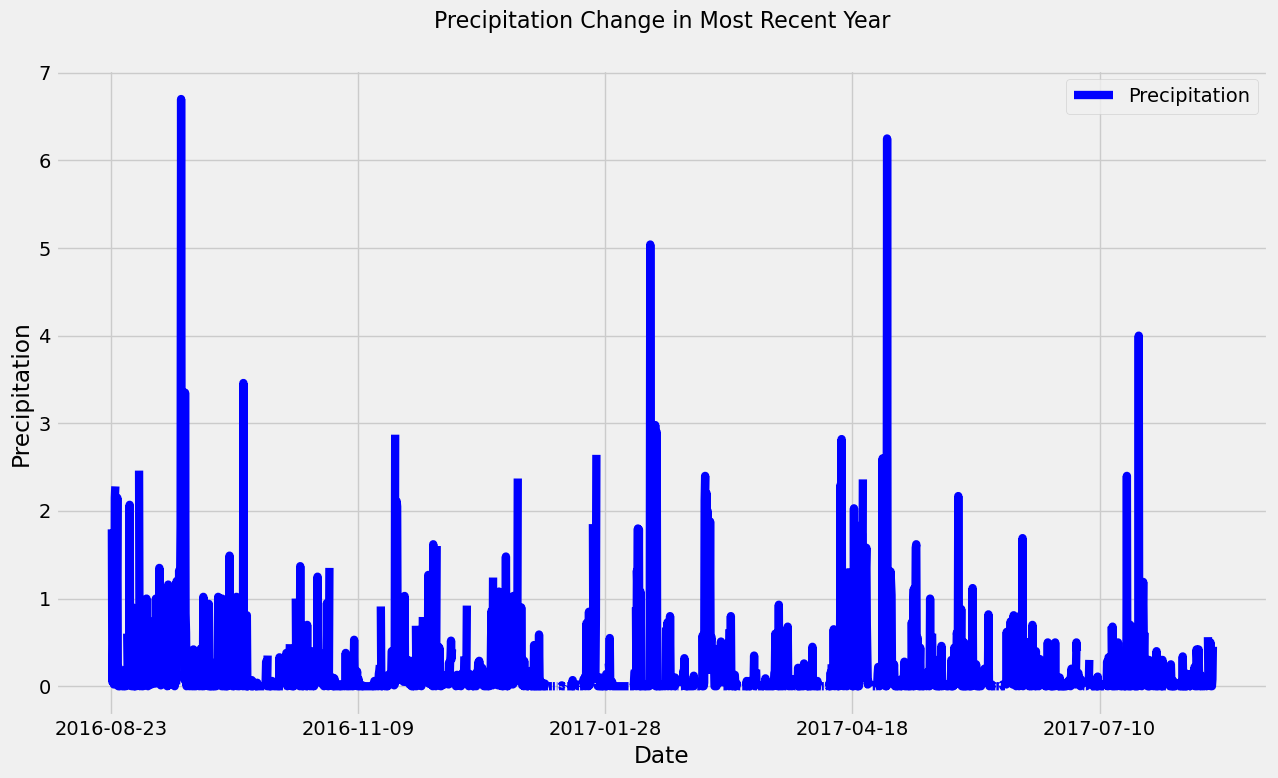

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
precipitation_data_df.plot(figsize=(13,8),linewidth=6,color='blue')
plt.title('Precipitation Change in Most Recent Year',fontsize= 16,pad=30)
plt.ylabel('Precipitation')
plt.savefig('output/Precipitation_Change_in_Most_Recent_Year.png') 
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset
total_number_stations = session.query(Measurement.station).distinct().count()
total_number_stations

9

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_1st = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

USC00519281_ = session.query(*station_1st).filter(Measurement.station == "USC00519281").all()
pd.DataFrame(USC00519281_,columns=['min','max','avg'],index=['USC00519281_'])

,min,max,avg
USC00519281_,54.0,85.0,71.663781


In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
last_12_months_tobs=session.query(Measurement.tobs).filter(Measurement.date >= last_12_months).filter(Measurement.station == "USC00519281").order_by(Measurement.date).all()
last_12_months_tobs_df = pd.DataFrame(last_12_months_tobs, columns=["tobs"])
last_12_months_tobs_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


<Figure size 2200x800 with 0 Axes>

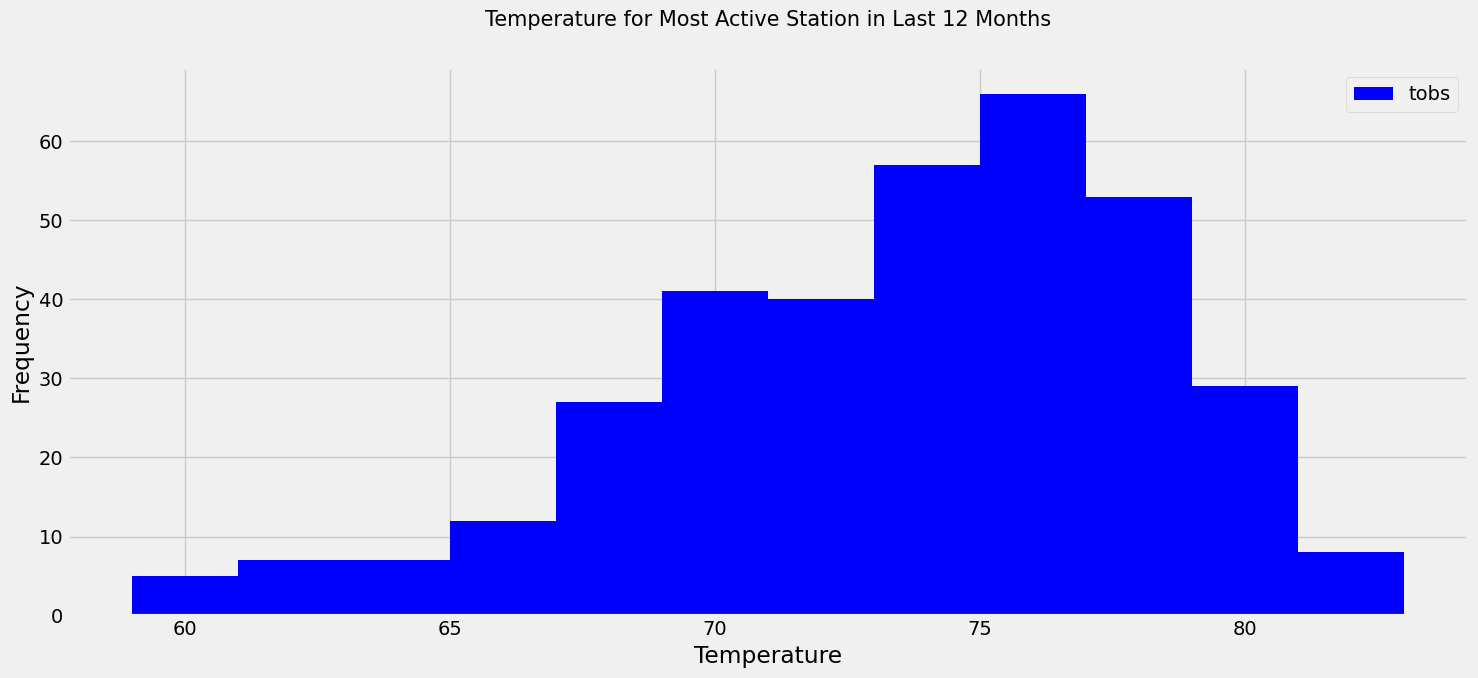

In [24]:
# Plot the results as a histogram
plt.figure(figsize=(22,8))
last_12_months_tobs_df.plot.hist(bins=12,color='blue')
plt.title('Temperature for Most Active Station in Last 12 Months',fontsize= 15,pad=30)
plt.xlabel('Temperature')
plt.gcf().set_size_inches(15, 7)
plt.savefig('output/Temperature_for_Most_Active_Station_in_Last_12_Months.png') 
plt.tight_layout()
plt.show()


# Close session

In [25]:
# Close Session
session.close()